In [1]:
import numpy as np
from dobbel import dobbellogger
from help_functies import *
from calibrator import calibrate
import matplotlib.pyplot as plt
dob = dobbellogger()

In [2]:
cali = calibrate(dob)
gyro_bias = cali['gyro bias']
acc_bias = cali['acc bias']
acc_std = cali['acc std']
gyro_std = cali['gyro std']

Leg de dobbelsteen met nummer  1  boven
wacht 3 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  2  boven
wacht 3 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  3  boven
wacht 3 secondes
Logging data for 2s
Done! The data is located in self.datadf


In [3]:
print(cali)

{'gyro bias': array([-0.17228457,  0.45849344, -0.05869384]), 'acc bias': array([-0.00080142,  0.02805087, -0.04472256]), 'gyro std': array([0.07165064, 0.06457009, 0.0692001 ]), 'acc std': array([0.0023304 , 0.00164414, 0.00210621])}


In [120]:
dob.connect()
dob.log(5, 100, 4, 2000)
dob.download()
data = dob.datadf

Logging data for 5s
Done! The data is located in self.datadf


In [121]:
# Deze code niet vaker dan 1 keer uitvoeren!
data = remove_nan(data)
data = rotate_data(data)

data['x_gyro'] = data['x_gyro'] - gyro_bias[0]
data['y_gyro'] = data['y_gyro'] - gyro_bias[1]
data['z_gyro'] = data['z_gyro'] - gyro_bias[2]
data['x_acc'] = data['x_acc'] - acc_bias[0]
data['y_acc'] = data['y_acc'] - acc_bias[1]
data['z_acc'] = data['z_acc'] - acc_bias[2]

In [122]:
data.head(2000)

,timestamp,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro
0,0.0,-0.015589,-0.047094,1.016782,0.251349,0.212238,-0.426508
1,10.0,-0.015686,-0.046117,1.029898,0.375482,0.151263,-0.482908
2,21.0,-0.015998,-0.047216,1.027761,-0.094010,-0.092640,-0.000025
3,31.0,-0.012857,-0.044897,1.025435,0.000764,-0.031664,0.076721
4,40.0,-0.013611,-0.042577,1.024038,0.030124,-0.031664,-0.056426
...,...,...,...,...,...,...,...
501,4878.0,-0.019964,-0.052709,1.024706,0.086524,-0.031664,0.067708
502,4888.0,-0.020588,-0.052465,1.027028,0.039137,-0.031664,0.029334
503,4899.0,-0.017958,-0.052831,1.027273,0.039137,-0.031664,0.029334
504,4907.0,-0.017818,-0.053564,1.026130,-0.046623,-0.031664,0.038348


In [123]:
for column in data.columns:
    print(column, np.mean(data[column]))

timestamp 2461.381422924901
x_acc -0.016274667532823625
y_acc -0.049676582097921564
z_acc 1.025875587381988
x_gyro -0.021834612093201023
y_gyro 0.03449865283719359
z_gyro 0.6890901229787414


In [124]:
y11 = np.array([data['x_acc'][0], data['y_acc'][0], data['z_acc'][0]])
gb = y11 / np.linalg.norm(y11)
gn = np.array([0, 0, 1])
mn = np.array([1, 0, 0])
ymb= np.array([1, 2, 3])
mb = np.cross(gb, np.cross(ymb / np.linalg.norm(ymb), gb))

A = - np.matmul(left_quat_mul(np.array([0, *gn])), right_quat_mul(np.array([0, *gb]))) #- np.matmul(left_quat_mul(np.array([0, *mn])), right_quat_mul(np.array([0, *mb])))

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(A)

# Eigenvalues are sorted in ascending order by np.linalg.eigh, 
# and the corresponding eigenvectors are columns of 'eigenvectors'
max_eigenvalue_index = np.argmax(eigenvalues)
max_eigenvector = eigenvectors[:, max_eigenvalue_index]
q11 = max_eigenvector

In [125]:
q11 = max_eigenvector

dqde = np.array([
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1]
])

sigma_etha = np.array([
    [(np.pi / 9) ** 2, 0, 0],
    [0, (np.pi / 9) ** 2, 0],
    [0, 0, (np.pi / 9) ** 2]
])

P11 = 0.25 * np.matmul(np.matmul(np.matmul(np.matmul(right_quat_mul(q11), dqde), sigma_etha), dqde.T), right_quat_mul(q11))
v1 = np.array([0,0,0])
p1 = np.array([0,0,0])

In [126]:
qtmin1tmin1 = np.reshape(q11, 4)
Ptmin1tmin1 = P11
vtmin1 = v1
ptmin1 = p1

q_list = [qtmin1tmin1]
v_list = [vtmin1]
p_list = [ptmin1]


Q = np.array([
    [gyro_std[0] ** 2, 0, 0],
    [0, gyro_std[1] ** 2, 0],
    [0, 0, gyro_std[2] ** 2]
])

R = np.array([
    [acc_std[0] ** 2, 0, 0],
    [0, acc_std[1] ** 2, 0],
    [0, 0, acc_std[2] ** 2],
])

epsilon_list = []

for i in range(1, len(data['timestamp'])):
    dt = (data['timestamp'][i] - data['timestamp'][i - 1]) / 1000
    gyro_measurement = np.array([data['x_gyro'][i], data['y_gyro'][i], data['z_gyro'][i]])
    omega = gyro_measurement
    expq_omega = expq(omega, 0.5 * dt * np.pi / 180)

    Ftmin1 = right_quat_mul(expq_omega)
    Gtmin1 = - 0.5 * dt * np.matmul(left_quat_mul(qtmin1tmin1), dqde)
    Pttmin1 = np.matmul(np.matmul(Ftmin1, Ptmin1tmin1), Ftmin1.T) + np.matmul(np.matmul(Gtmin1, Q), Gtmin1.T)
    qttmin1 = quat_mul(qtmin1tmin1, expq_omega)
    
    q0, q1, q2, q3 = qttmin1
    H = 2 * np.array([
        [-q2, q3, -q0, q1],
        [q1, q0, q3, q2],
        [2 * q0, 0, 0, 2 * q3]
    ])

    S = np.matmul(np.matmul(H, Pttmin1), H.T) + R
    K = np.matmul(np.matmul(Pttmin1, H.T), np.linalg.inv(S))

    yat = np.array([data['x_acc'][i], data['y_acc'][i], data['z_acc'][i]])
    yattmin1 = rotate_vector(gn, quaternion_conjugate(qttmin1))
    yateps = yat / np.linalg.norm(yat)
    epsilon = yateps - yattmin1
    q_tt_measure = np.reshape(qttmin1, (4, 1)) + np.matmul(K, np.reshape(epsilon, (3, 1)))
    Ptt = Pttmin1 - np.matmul(np.matmul(K, H), Pttmin1)
    qtt = q_tt_measure / ((np.linalg.norm(q_tt_measure)))
    
    an = rotate_vector(yat, np.reshape(qtt, 4)) - gn
    print(an)
    an = an * 9.81
    vt = vtmin1 + dt * an
    pt = ptmin1 + dt * vtmin1 + 0.5 * an * dt ** 2 

    Ptmin1tmin1 = Ptt
    qtmin1tmin1 = np.reshape(qtt, 4)
    ptmin1 = pt
    vtmin1 = vt

    q_list.append(qtmin1tmin1)
    epsilon_list.append(epsilon)
    p_list.append(ptmin1)
    v_list.append(vtmin1)

[-4.53359921e-08 -4.81127736e-08  3.10492529e-02]
[-0.00017358 -0.00052643  0.02896904]
[0.00182632 0.00097165 0.02649537]
[0.00081821 0.00199897 0.02501121]
[0.00106811 0.00093575 0.0249519 ]
[ 0.00150273 -0.00249564  0.02555304]
[-0.00101693 -0.00135781  0.0260599 ]
[-0.00075151 -0.00236925  0.02607262]
[-0.00015349 -0.00216634  0.02640242]
[-0.00104015 -0.00145571  0.02916763]
[-0.00124389  0.00102127  0.02893225]
[0.00146555 0.00098149 0.02470152]
[0.0010742  0.00210389 0.02408194]
[0.00100728 0.00211762 0.02608977]
[0.00132355 0.00227272 0.02533739]
[0.00052843 0.00127247 0.02612066]
[0.0011467  0.00038889 0.0260262 ]
[ 0.00055968 -0.00141551  0.02539665]
[-0.00059037 -0.00297931  0.02360038]
[-0.00059411 -0.00228386  0.02381546]
[-0.00155875 -0.00215319  0.02573571]
[-0.00209497 -0.00217099  0.02835618]
[-0.00232898 -0.00015567  0.02733911]
[-0.00310745  0.00049064  0.02760215]
[0.00070773 0.00064071 0.02499822]
[0.00201551 0.00141777 0.02565191]
[0.00203305 0.00161827 0.02578941

In [127]:
rotvec_x = []
rotvec_y = []
rotvec_z = []

for q, timestamp in zip(q_list, data['timestamp']):
    euler = quaternion_to_euler(q) * 180 / np.pi
    rotvec_x.append(euler[0])
    rotvec_y.append(euler[1])
    rotvec_z.append(euler[2])

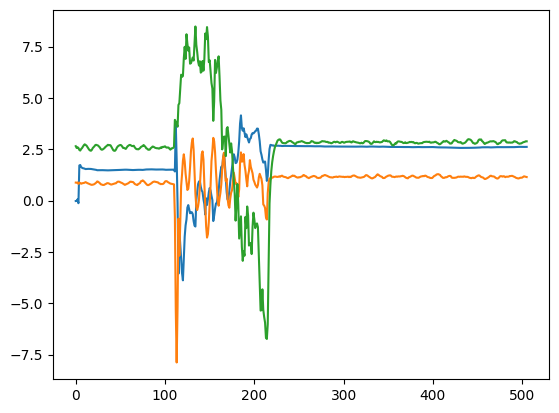

In [128]:
plt.plot(rotvec_x)
plt.plot(rotvec_y)
plt.plot(rotvec_z)

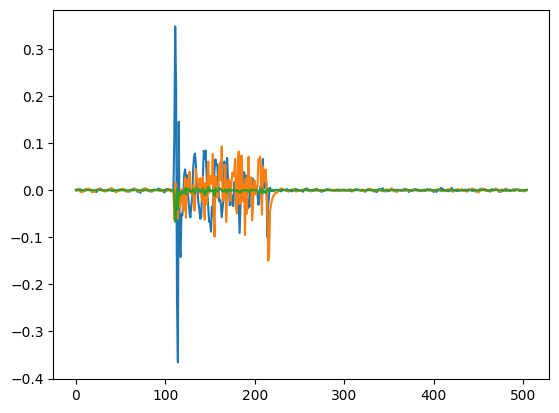

In [129]:
epsilons = np.concatenate(epsilon_list)
epsilons = np.reshape(epsilons, (int(len(epsilons) / 3), 3))

plt.plot(epsilons[:, 0])
plt.plot(epsilons[:, 1])
plt.plot(epsilons[:, 2])

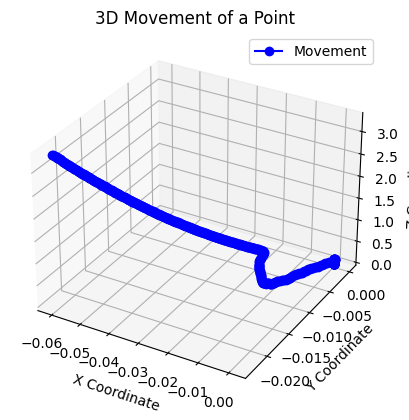

In [130]:
positions = np.reshape(np.concatenate(p_list), (int(len(p_list)), 3))
# Create a new figure for the 3D plot
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Plot the movement of the point
ax.plot(positions[:,0], positions[:,1], positions[:,2], marker='o', linestyle='-', color='b', label='Movement')

# Set labels for each axis
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')

# Set a title
ax.set_title('3D Movement of a Point')

# Add a legend
ax.legend()

# Show the plot
plt.show()


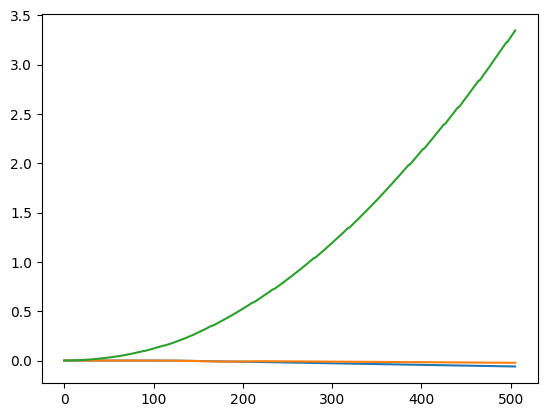

In [133]:
plt.plot(positions[:,0])
plt.plot(positions[:,1])
plt.plot(positions[:,2])
plt.show()